# Problem Statement-LTFS Data Science FinHack ( ML Hackathon)

### Vehicle Loan Default Prediction

* Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default. A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided in the datasets:
* Loanee Information (Demographic data like age, Identity proof etc.)
* Loan Information (Disbursal details, loan to value ratio etc.)
* Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)
* Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.  

# Data Description

#### train.csv 

It contains the training data with details on loan as described in the last section

#### data_dictionary.csv 

It contains a brief description on each variable provided in the training and test set.

#### test.csv

test.csv contains details of all customers and loans for which the participants are to submit probability of default.  

#### sample_submission.csv

sample_submission.csv contains the submission format for the predictions against the test set. A single csv (not zip) needs to be submitted as a solution.

#### Evaluation Metric

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.  

In [1]:
# Load required libraries
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plottingimport pandas as pd
import pandas as pd
import numpy as np
import os

from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib 
%matplotlib inline

from sklearn import model_selection
from sklearn.utils import resample

# Importing classification models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pprint import pprint



### Import Data and basic data manipulation with Python Data Analysis Library(pandas)

In [2]:
# Read data
dataset=pd.read_csv("train.csv",skipinitialspace=True)
test_data=pd.read_csv("test.csv",skipinitialspace=True)

In [3]:
#Shape of the data
print(dataset.shape)
print('-' * 13)
print(test_data.shape)

(233154, 41)
-------------
(112392, 40)


### Target feature count check

In [4]:
dataset['loan_default'].value_counts()
# Circa 79% & 21% == 0(No Defaulted) & 1(Defaulted)
# A little imbalanced data

0    182543
1     50611
Name: loan_default, dtype: int64

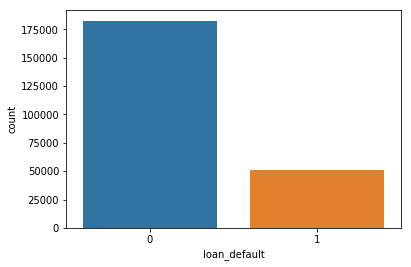

In [5]:
sns.countplot(x="loan_default", data=dataset),
plt.show()

### Exploratory Data Analysis and Visualisation

/Users/priyavivekbhandarkar/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


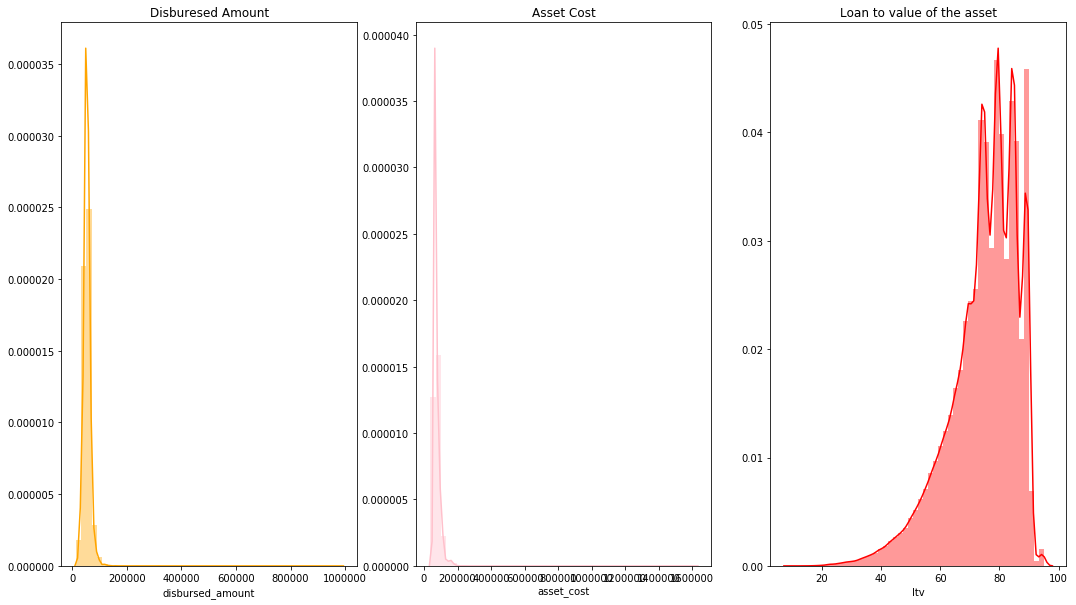

In [6]:
# check the distribution of disbursed amount, Asset Cost, ltv

plt.rcParams['figure.figsize'] = (18, 10)

plt.subplot(1, 3, 1)
sns.distplot(dataset['disbursed_amount'],  color = 'orange')
plt.title('Disburesed Amount')


plt.subplot(1, 3, 2)
sns.distplot(dataset['asset_cost'], color = 'pink')
plt.title('Asset Cost')

plt.subplot(1, 3, 3)
sns.distplot(dataset['ltv'], color = 'red')
plt.title('Loan to value of the asset')

plt.show()

Text(0.5, 1.0, 'No. of Inquiries')

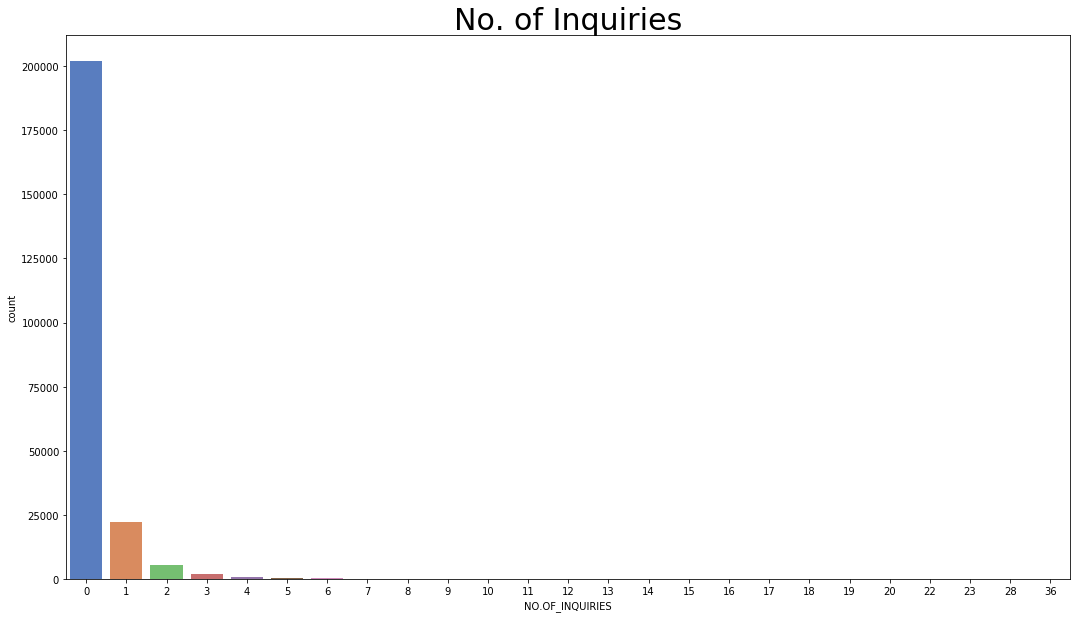

In [7]:
# plotting a countplot

sns.countplot(dataset['NO.OF_INQUIRIES'], palette = 'muted')
plt.title('No. of Inquiries',  fontsize = 30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

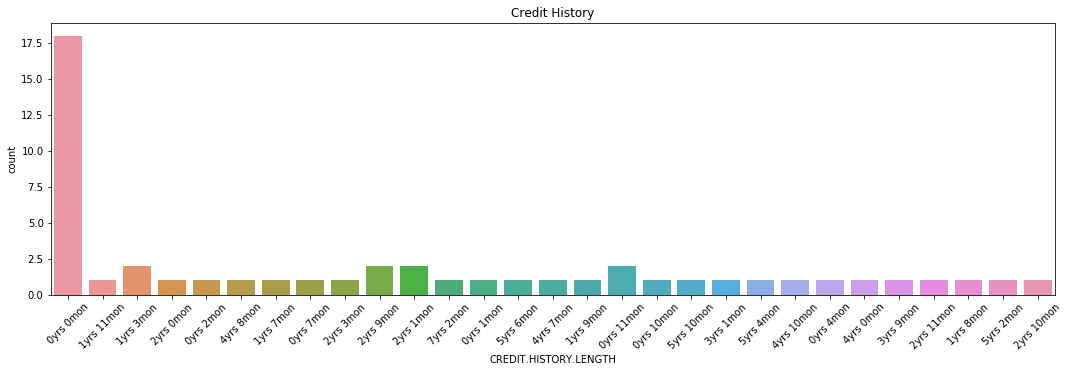

In [8]:
# plotting countplot for credit history of users

plt.rcParams['figure.figsize'] = (18, 5)
sns.countplot(dataset['CREDIT.HISTORY.LENGTH'].head(50))
plt.title('Credit History')
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

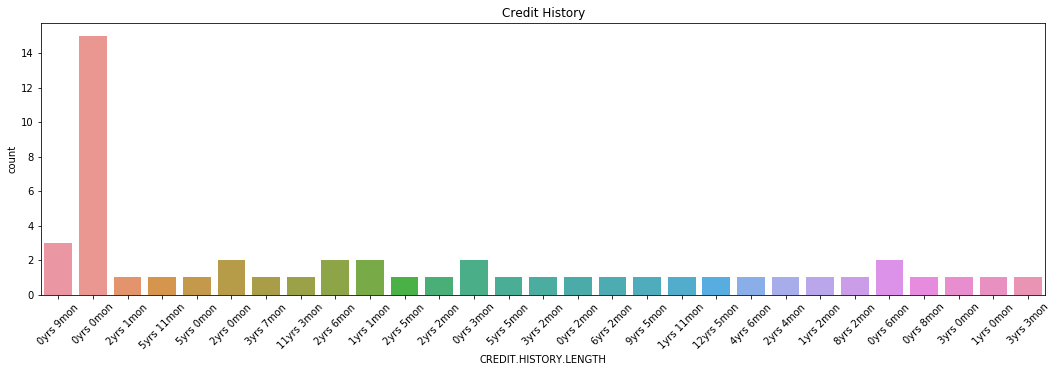

In [9]:
# plotting countplot for credit history of users

plt.rcParams['figure.figsize'] = (18, 5)
sns.countplot(dataset['CREDIT.HISTORY.LENGTH'].tail(50))
plt.title('Credit History')
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

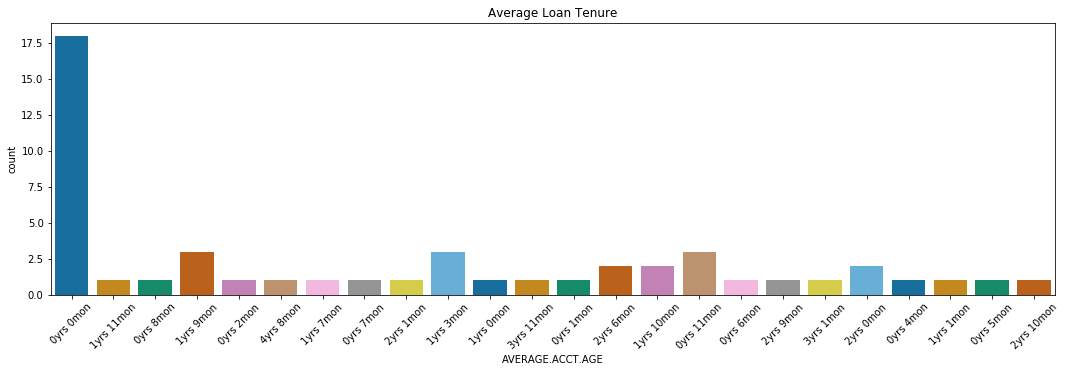

In [10]:
# average.acct.age i.e., average loan tenure - head

sns.countplot(dataset['AVERAGE.ACCT.AGE'].head(50), palette = 'colorblind')
plt.title('Average Loan Tenure')
plt.xticks(rotation = 45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

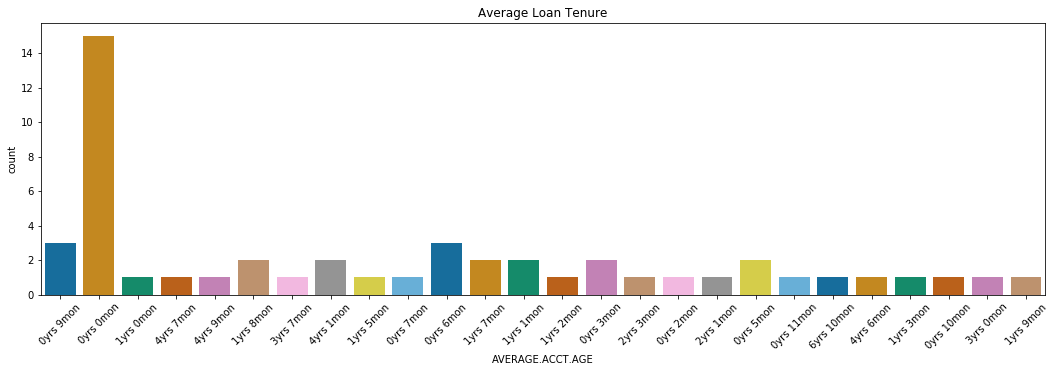

In [11]:
# average.acct.age i.e., average loan tenure -tail

sns.countplot(dataset['AVERAGE.ACCT.AGE'].tail(50), palette = 'colorblind')
plt.title('Average Loan Tenure')
plt.xticks(rotation = 45)

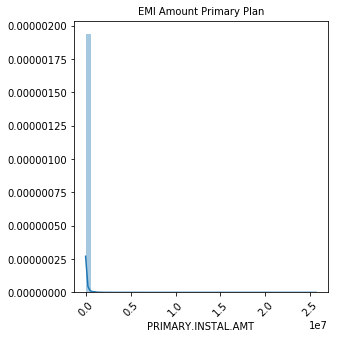

In [12]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplot(1, 2, 2)
sns.distplot(dataset['PRIMARY.INSTAL.AMT'])
plt.title('EMI Amount Primary Plan', fontsize = 10)
plt.xticks(rotation = 45)
plt.show()

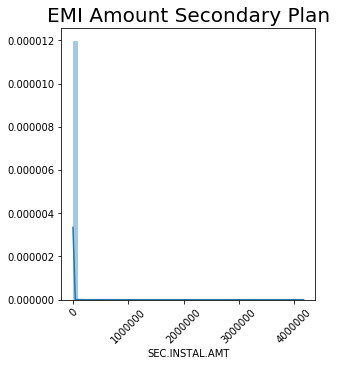

In [13]:
# EMI Amount of the Secondary Plan

plt.subplot(1, 2, 1)
sns.distplot(dataset['SEC.INSTAL.AMT'])
plt.title('EMI Amount Secondary Plan', fontsize = 20)
plt.xticks(rotation = 45)
plt.show()

(array([-5000000.,        0.,  5000000., 10000000., 15000000., 20000000.,
        25000000., 30000000., 35000000.]),
 <a list of 9 Text xticklabel objects>)

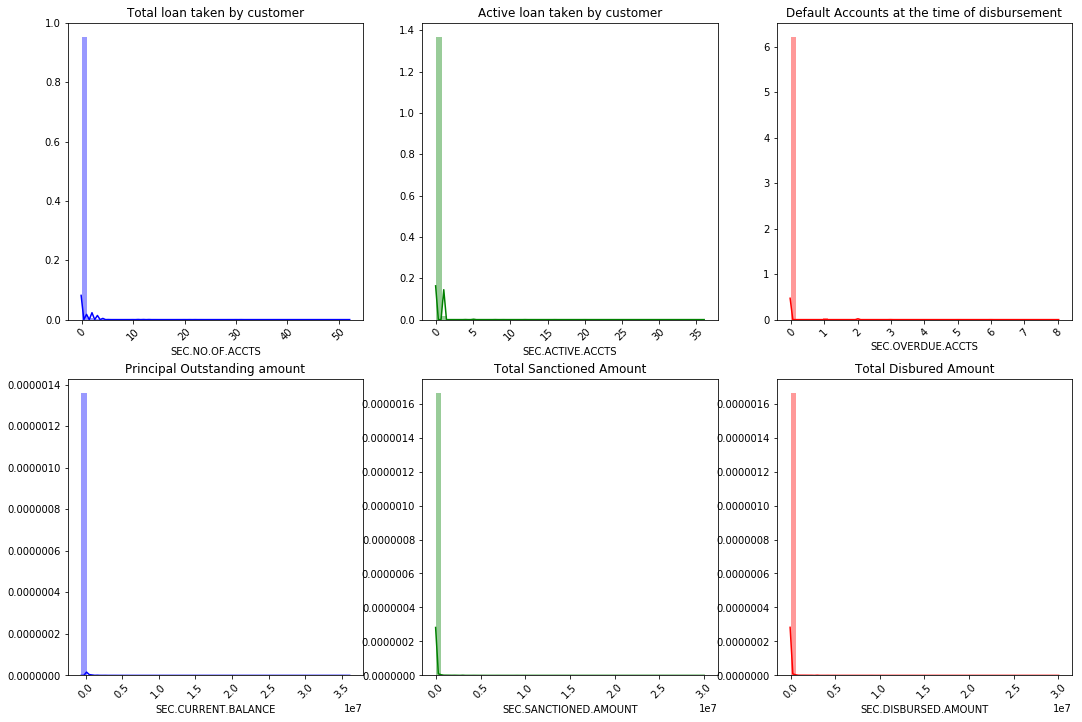

In [14]:
# distribution for different attributesof secondary accounts


plt.rcParams['figure.figsize'] = (18, 12)    
plt.subplot(2, 3, 1)
sns.distplot(dataset['SEC.NO.OF.ACCTS'], color = 'blue')
plt.title('Total loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 2)
sns.distplot(dataset['SEC.ACTIVE.ACCTS'], color = 'green')
plt.title('Active loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 3)
sns.distplot(dataset['SEC.OVERDUE.ACCTS'], color = 'red')
plt.title('Default Accounts at the time of disbursement')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 4)
sns.distplot(dataset['SEC.CURRENT.BALANCE'], color = 'blue')
plt.title('Principal Outstanding amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 5)
sns.distplot(dataset['SEC.SANCTIONED.AMOUNT'], color = 'green')
plt.title('Total Sanctioned Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 6)
sns.distplot(dataset['SEC.DISBURSED.AMOUNT'], color = 'red')
plt.title('Total Disbured Amount')
plt.xticks(rotation = 45)

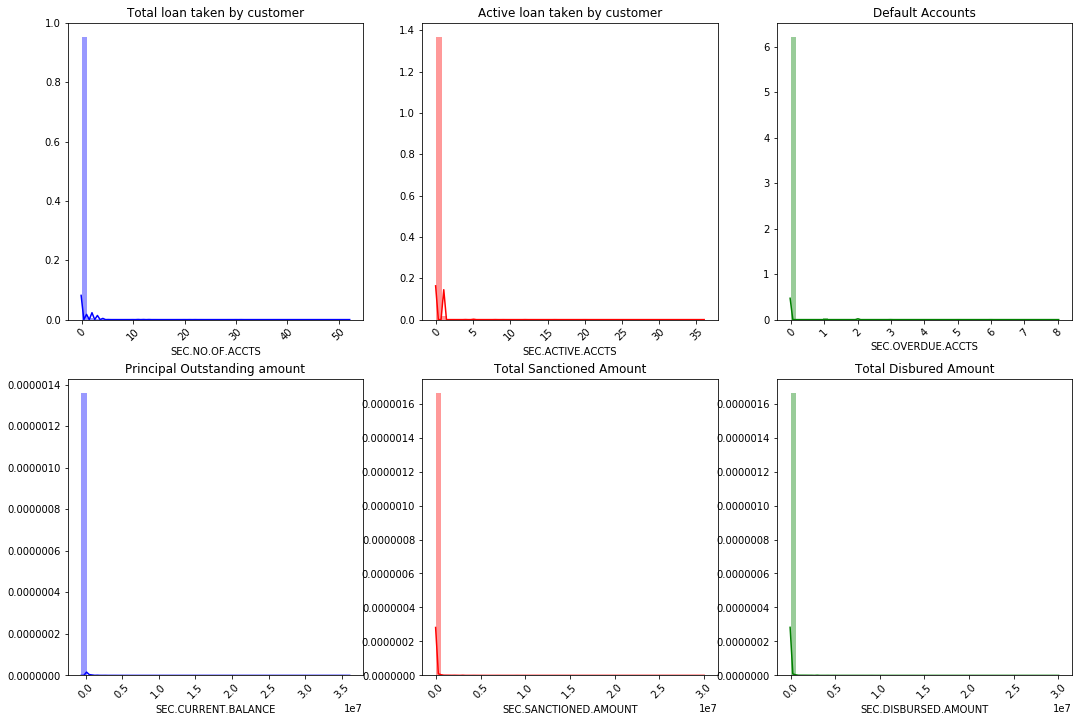

In [15]:
plt.rcParams['figure.figsize'] = (18, 12)    
plt.subplot(2, 3, 1)
sns.distplot(dataset['SEC.NO.OF.ACCTS'], color = 'blue')
plt.title('Total loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 2)
sns.distplot(dataset['SEC.ACTIVE.ACCTS'], color = 'red')
plt.title('Active loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 3)
sns.distplot(dataset['SEC.OVERDUE.ACCTS'], color = 'green')
plt.title('Default Accounts')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 4)
sns.distplot(dataset['SEC.CURRENT.BALANCE'], color = 'blue')
plt.title('Principal Outstanding amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 5)
sns.distplot(dataset['SEC.SANCTIONED.AMOUNT'], color = 'red')
plt.title('Total Sanctioned Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 6)
sns.distplot(dataset['SEC.DISBURSED.AMOUNT'], color = 'green')
plt.title('Total Disbured Amount')
plt.xticks(rotation = 45)

plt.show()

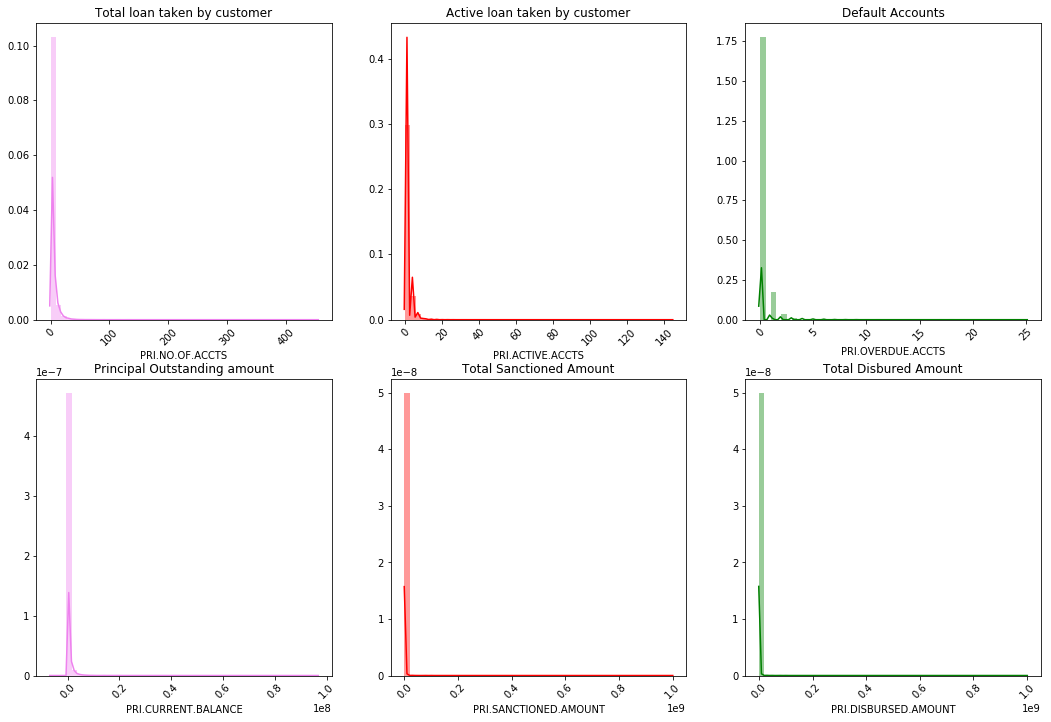

In [16]:
# plotting distribution plots for these attributes

plt.rcParams['figure.figsize'] = (18, 12)    
plt.subplot(2, 3, 1)
sns.distplot(dataset['PRI.NO.OF.ACCTS'], color = 'violet')
plt.title('Total loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 2)
sns.distplot(dataset['PRI.ACTIVE.ACCTS'], color = 'red')
plt.title('Active loan taken by customer')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 3)
sns.distplot(dataset['PRI.OVERDUE.ACCTS'], color = 'green')
plt.title('Default Accounts')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 4)
sns.distplot(dataset['PRI.CURRENT.BALANCE'], color = 'violet')
plt.title('Principal Outstanding amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 5)
sns.distplot(dataset['PRI.SANCTIONED.AMOUNT'], color = 'red')
plt.title('Total Sanctioned Amount')
plt.xticks(rotation = 45)

plt.subplot(2, 3, 6)
sns.distplot(dataset['PRI.DISBURSED.AMOUNT'], color = 'green')
plt.title('Total Disbured Amount')
plt.xticks(rotation = 45)

plt.show()

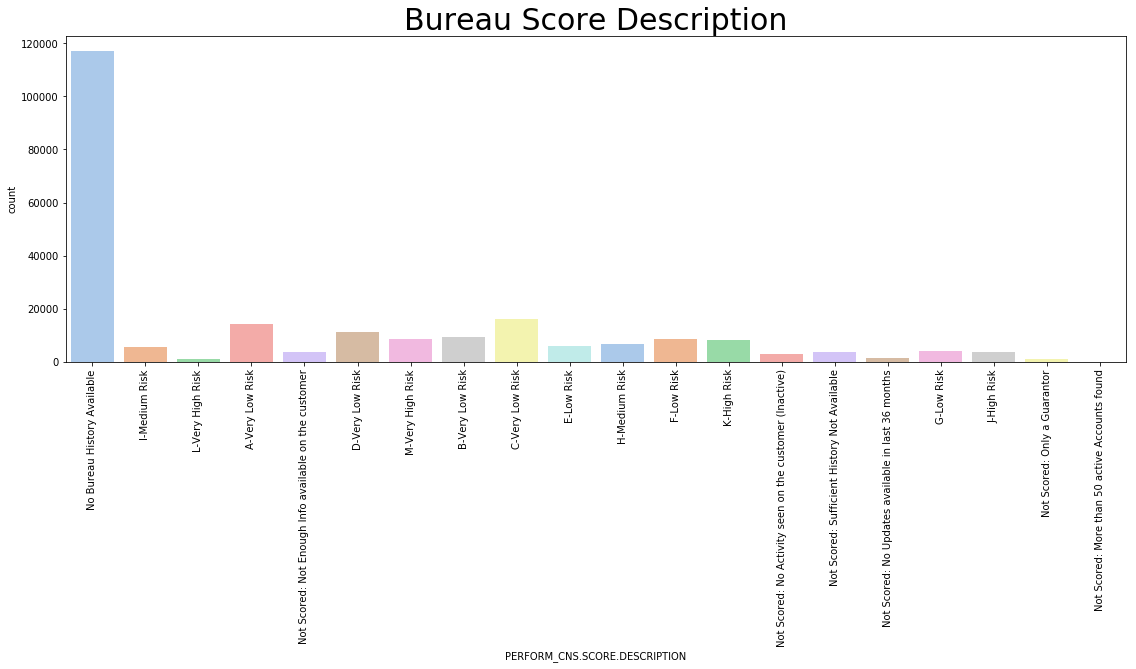

In [17]:
# checking the bureau score description

plt.rcParams['figure.figsize'] = (19, 6)
sns.countplot(dataset['PERFORM_CNS.SCORE.DESCRIPTION'], palette = 'pastel')
plt.title('Bureau Score Description', fontsize = 30)
plt.xticks(rotation = 90)
plt.show()

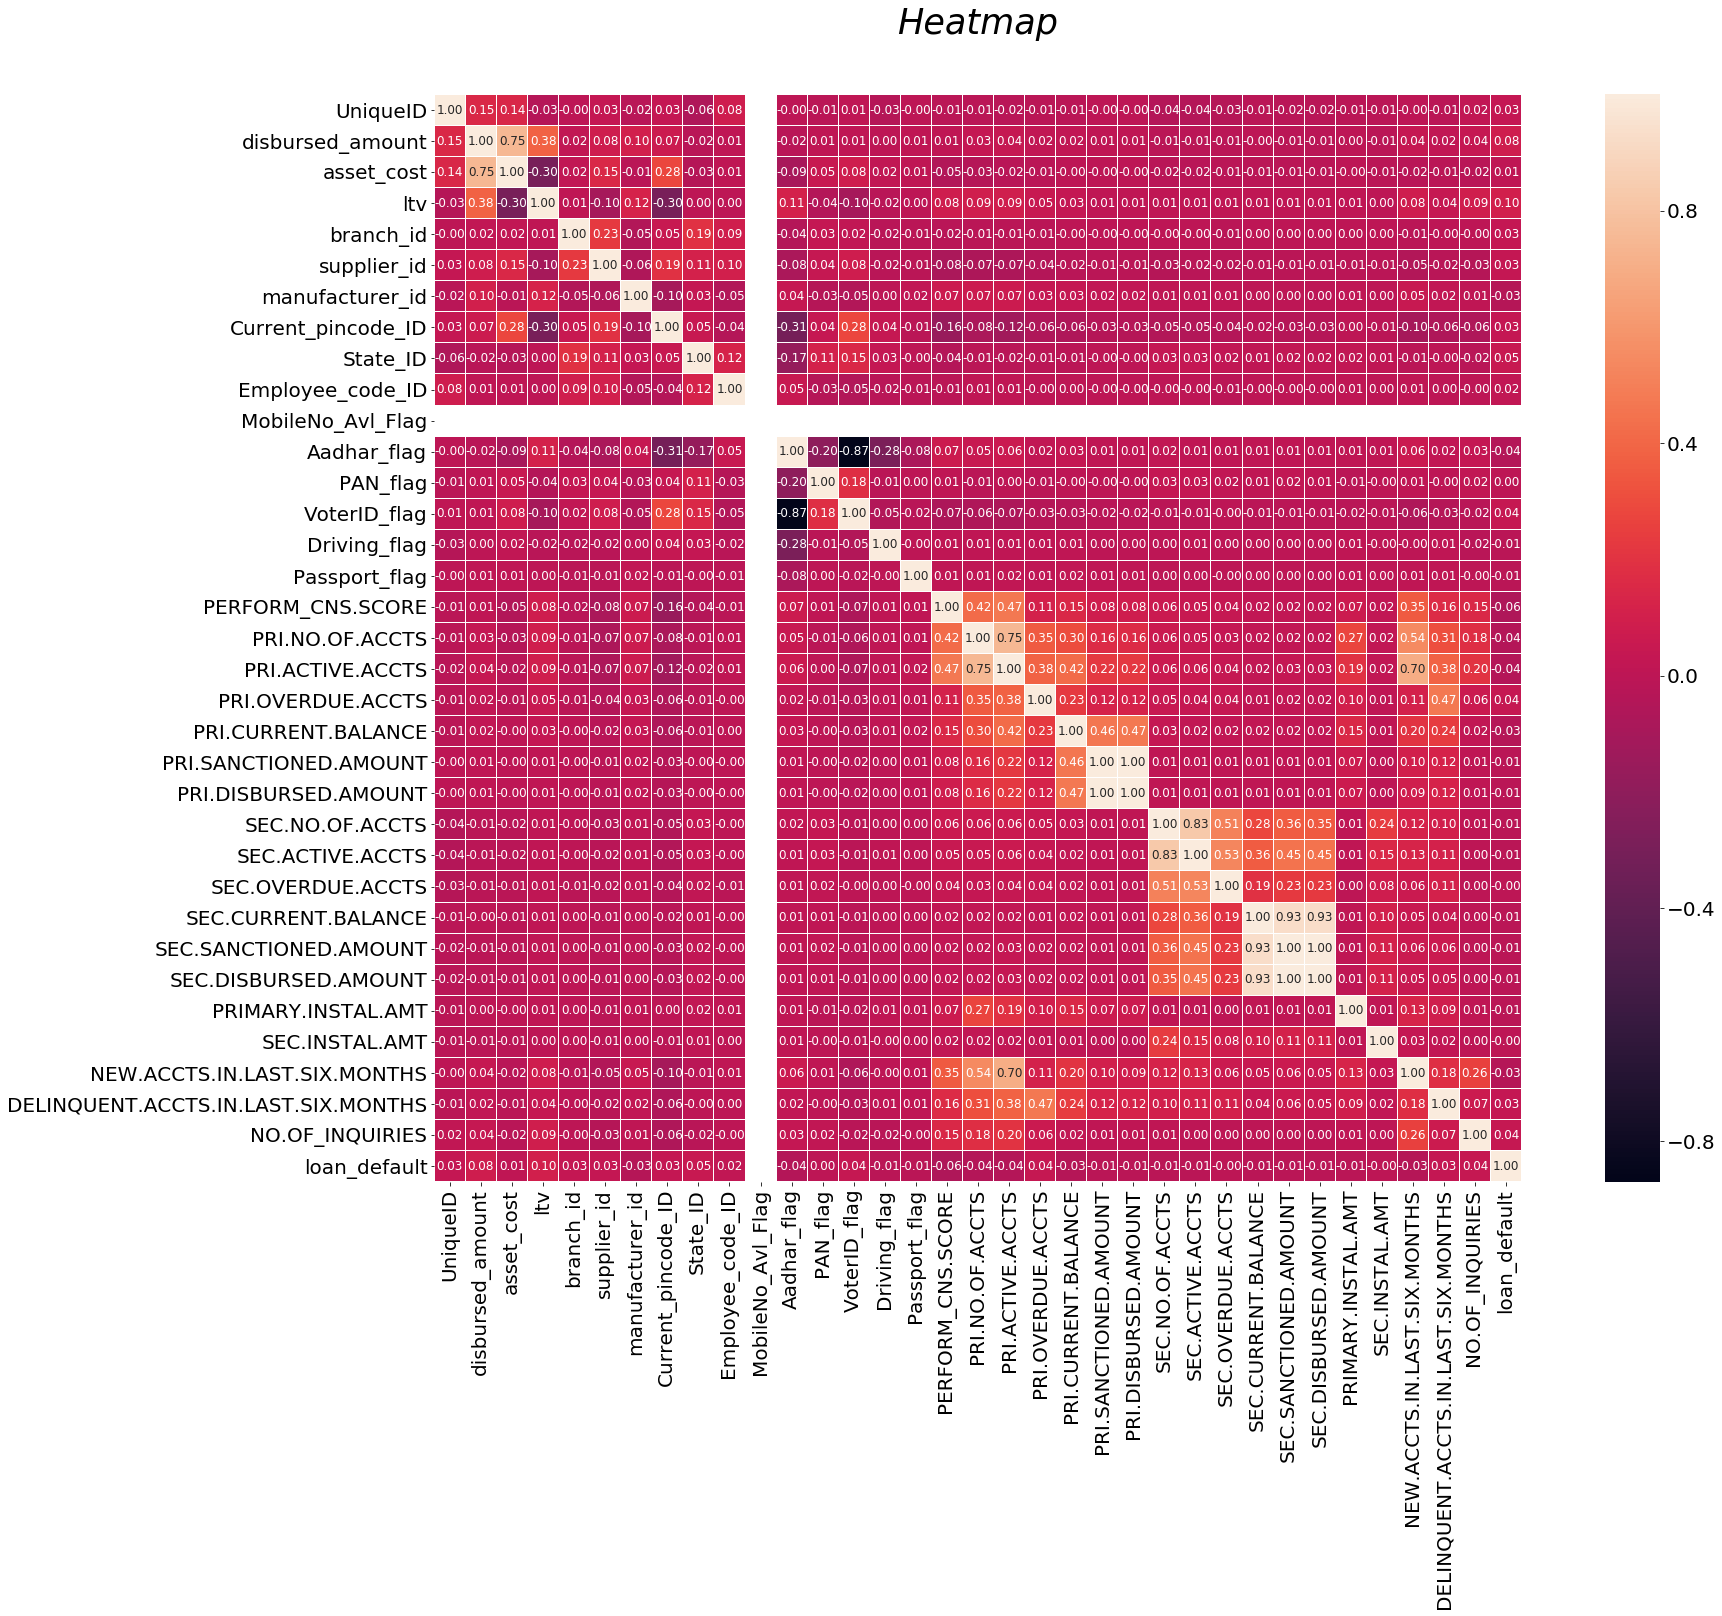

In [18]:
correlation_matrix = dataset.corr().round(2)
# annot = True to print the values inside the square
#plt.figure(figsize=(8, 8))  fmt="d"
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(figsize=(30,20))# Sample figsize in inchesTrue
#title for heatmap
title = "Heatmap"
plt.title(title, fontsize = 35,color='Black', fontstyle='italic')
ttl = ax.title
ttl.set_position([0.5, 1.05])
p=sns.heatmap(data=correlation_matrix, annot=True, fmt=".2f", linewidths=0.005, ax=ax, square=True, annot_kws={"size": 12})
plt.show()

### Data Preprocessing after EDA and Visualisation

In [19]:
# Train data-changing the average account age format from years and months to two seperate columns years and months
dataset['AVERAGE.ACCT.AGE.YEARS'] = dataset['AVERAGE.ACCT.AGE'].apply(lambda x: x.split('yrs')[0])
dataset['AVERAGE.ACCT.AGE.MONTHS'] = dataset['AVERAGE.ACCT.AGE'].apply(lambda x: x.split('yrs ')[0])

In [20]:
dataset['AVERAGE.ACCT.AGE']=0

In [21]:
# Float conversion for applying computation
dataset['AVERAGE.ACCT.AGE']=dataset['AVERAGE.ACCT.AGE'].astype('float64')
dataset['AVERAGE.ACCT.AGE.YEARS']=dataset['AVERAGE.ACCT.AGE.YEARS'].astype('float64')
dataset['AVERAGE.ACCT.AGE.MONTHS']=dataset['AVERAGE.ACCT.AGE.MONTHS'].astype('float64')

In [22]:
# Replacing AVERAGE.ACCT.AGE with single value combined in months
dataset['AVERAGE.ACCT.AGE']=dataset['AVERAGE.ACCT.AGE.YEARS']*12 +dataset['AVERAGE.ACCT.AGE.MONTHS']

In [23]:
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,AVERAGE.ACCT.AGE.YEARS,AVERAGE.ACCT.AGE.MONTHS
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0.0,0yrs 0mon,0,0,0.0,0.0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,1991,0,0,1,13.0,1yrs 11mon,0,1,1.0,1.0
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0.0,0yrs 0mon,0,0,0.0,0.0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,31,0,0,0,0.0,1yrs 3mon,1,1,0.0,0.0
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0.0,0yrs 0mon,1,1,0.0,0.0


In [24]:
# Dropping temporary columns
dataset=dataset.drop(columns='AVERAGE.ACCT.AGE.YEARS')
dataset=dataset.drop(columns='AVERAGE.ACCT.AGE.MONTHS')

In [25]:
# Test Data-changing the average account age format from years and months to two seperate columns years and months
test_data['AVERAGE.ACCT.AGE.YEARS'] = test_data['AVERAGE.ACCT.AGE'].apply(lambda x: x.split('yrs')[0])
test_data['AVERAGE.ACCT.AGE.MONTHS'] = test_data['AVERAGE.ACCT.AGE'].apply(lambda x: x.split('yrs ')[0])

In [26]:
test_data['AVERAGE.ACCT.AGE']=0

In [27]:
# Float conversion for applying computation
test_data['AVERAGE.ACCT.AGE']=test_data['AVERAGE.ACCT.AGE'].astype('float64')
test_data['AVERAGE.ACCT.AGE.YEARS']=test_data['AVERAGE.ACCT.AGE.YEARS'].astype('float64')
test_data['AVERAGE.ACCT.AGE.MONTHS']=test_data['AVERAGE.ACCT.AGE.MONTHS'].astype('float64')

In [28]:
# Replacing AVERAGE.ACCT.AGE with single value combined in months
test_data['AVERAGE.ACCT.AGE']=test_data['AVERAGE.ACCT.AGE.YEARS']*12 +test_data['AVERAGE.ACCT.AGE.MONTHS']

In [29]:
test_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,AVERAGE.ACCT.AGE.YEARS,AVERAGE.ACCT.AGE.MONTHS
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,...,0,0,0,0,0,0.0,0yrs 0mon,0,0.0,0.0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,...,0,5605,0,1,0,0.0,1yrs 0mon,1,0.0,0.0
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,...,0,0,0,0,0,0.0,0yrs 0mon,0,0.0,0.0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,...,0,0,0,0,0,26.0,2yrs 5mon,0,2.0,2.0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,...,0,0,0,0,0,0.0,0yrs 0mon,0,0.0,0.0


In [30]:
# Dropping temporary columns
test_data=test_data.drop(columns='AVERAGE.ACCT.AGE.YEARS')
test_data=test_data.drop(columns='AVERAGE.ACCT.AGE.MONTHS')

In [31]:
# Train data-changing the average account age format from years and months to two seperate columns years and months
dataset['CREDIT.HISTORY.LENGTH.YEARS'] = dataset['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split('yrs')[0])
dataset['CREDIT.HISTORY.LENGTH.MONTHS'] = dataset['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split('yrs ')[0])

In [32]:
dataset['CREDIT.HISTORY.LENGTH']=0

In [33]:
# Float conversion for applying computation
dataset['CREDIT.HISTORY.LENGTH']=dataset['CREDIT.HISTORY.LENGTH'].astype('float64')
dataset['CREDIT.HISTORY.LENGTH.YEARS']=dataset['CREDIT.HISTORY.LENGTH.YEARS'].astype('float64')
dataset['CREDIT.HISTORY.LENGTH.MONTHS']=dataset['CREDIT.HISTORY.LENGTH.MONTHS'].astype('float64')

In [34]:
# Replacing CREDIT.HISTORY.LENGTH with single value combined in months
dataset['CREDIT.HISTORY.LENGTH']=dataset['CREDIT.HISTORY.LENGTH.YEARS']*12 +dataset['CREDIT.HISTORY.LENGTH.MONTHS']

In [35]:
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,CREDIT.HISTORY.LENGTH.YEARS,CREDIT.HISTORY.LENGTH.MONTHS
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0.0,0.0,0,0,0.0,0.0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,1991,0,0,1,13.0,13.0,0,1,1.0,1.0
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0.0,0.0,0,0,0.0,0.0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,31,0,0,0,0.0,13.0,1,1,1.0,1.0
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0.0,0.0,1,1,0.0,0.0


In [36]:
# Dropping temporary columns
dataset=dataset.drop(columns='CREDIT.HISTORY.LENGTH.YEARS')
dataset=dataset.drop(columns='CREDIT.HISTORY.LENGTH.MONTHS')

In [37]:
# Train data-changing the average account age format from years and months to two seperate columns years and months
test_data['CREDIT.HISTORY.LENGTH.YEARS'] = test_data['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split('yrs')[0])
test_data['CREDIT.HISTORY.LENGTH.MONTHS'] = test_data['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split('yrs ')[0])

In [38]:
test_data['CREDIT.HISTORY.LENGTH']=0

In [39]:
# Float conversion for applying computation
test_data['CREDIT.HISTORY.LENGTH']=test_data['CREDIT.HISTORY.LENGTH'].astype('float64')
test_data['CREDIT.HISTORY.LENGTH.YEARS']=test_data['CREDIT.HISTORY.LENGTH.YEARS'].astype('float64')
test_data['CREDIT.HISTORY.LENGTH.MONTHS']=test_data['CREDIT.HISTORY.LENGTH.MONTHS'].astype('float64')

In [40]:
# Replacing CREDIT.HISTORY.LENGTH with single value combined in months
test_data['CREDIT.HISTORY.LENGTH']=test_data['CREDIT.HISTORY.LENGTH.YEARS']*12 +test_data['CREDIT.HISTORY.LENGTH.MONTHS']

In [41]:
test_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,CREDIT.HISTORY.LENGTH.YEARS,CREDIT.HISTORY.LENGTH.MONTHS
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,...,0,0,0,0,0,0.0,0.0,0,0.0,0.0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,...,0,5605,0,1,0,0.0,13.0,1,1.0,1.0
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,...,0,0,0,0,0,0.0,0.0,0,0.0,0.0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,...,0,0,0,0,0,26.0,26.0,0,2.0,2.0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,...,0,0,0,0,0,0.0,0.0,0,0.0,0.0


In [42]:
# Dropping temporary columns
test_data=test_data.drop(columns='CREDIT.HISTORY.LENGTH.YEARS')
test_data=test_data.drop(columns='CREDIT.HISTORY.LENGTH.MONTHS')

In [43]:
# Encodings for perform cns score distribution
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('No Bureau History Available', 0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Sufficient History Not Available', 0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Not Enough Info available on the customer', 0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: No Activity seen on the customer (Inactive)',0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: No Updates available in last 36 months', 0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Only a Guarantor', 0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: More than 50 active Accounts found',0)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('M-Very High Risk', 1)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('L-Very High Risk', 1)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('K-High Risk', 2)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('J-High Risk', 2)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('I-Medium Risk', 3)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('H-Medium Risk', 3)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('G-Low Risk', 4)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('F-Low Risk', 4)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('E-Low Risk', 4)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('D-Very Low Risk', 5)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('C-Very Low Risk', 5)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('B-Very Low Risk', 5)
dataset['PERFORM_CNS.SCORE.DESCRIPTION'] = dataset['PERFORM_CNS.SCORE.DESCRIPTION'].replace('A-Very Low Risk', 5)

# Checking the values in bureau score
dataset['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

0    129785
5     50728
4     18294
3     12412
2     12025
1      9910
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [44]:
# Encodings for bureau score(perform cns score distribution)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('No Bureau History Available', 0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Sufficient History Not Available', 0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Not Enough Info available on the customer', 0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: No Activity seen on the customer (Inactive)',0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: No Updates available in last 36 months', 0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: Only a Guarantor', 0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('Not Scored: More than 50 active Accounts found',0)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('M-Very High Risk', 1)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('L-Very High Risk', 1)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('K-High Risk', 2)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('J-High Risk', 2)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('I-Medium Risk', 3)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('H-Medium Risk', 3)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('G-Low Risk', 4)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('F-Low Risk', 4)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('E-Low Risk', 4)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('D-Very Low Risk', 5)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('C-Very Low Risk', 5)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('B-Very Low Risk', 5)
test_data['PERFORM_CNS.SCORE.DESCRIPTION'] = test_data['PERFORM_CNS.SCORE.DESCRIPTION'].replace('A-Very Low Risk', 5)

# Checking the values in bureau score
test_data['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

0    63017
5    24993
4     8070
3     5990
2     5642
1     4680
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [45]:
# To be convertible in Categories/One hot encoding
dataset['State_ID'].value_counts()

4     44870
3     34078
6     33505
13    17884
9     16022
8     14197
5     10177
14     9414
1      8936
7      6786
11     6721
18     5412
15     5049
12     4210
2      4160
17     3991
10     3605
16     2685
19     1035
20      185
21      156
22       76
Name: State_ID, dtype: int64

In [46]:
# Not to be convertible in categorical levels as so many levels are there
dataset['supplier_id'].value_counts()

18317    1432
15694    1300
15663    1275
17980    1268
14234    1258
18166    1210
21980    1125
14375    1119
22727    1062
14145    1060
14115    1042
21124    1032
18532    1009
18473     976
14347     963
14178     887
15142     816
14770     795
21043     764
14791     762
16633     737
20470     714
21003     710
21556     710
20292     707
14078     686
16565     678
23137     661
14293     659
16694     641
         ... 
15490       1
23438       1
23575       1
24679       1
21963       1
24592       1
16677       1
23463       1
22562       1
24715       1
24498       1
20943       1
20613       1
20869       1
24659       1
23551       1
22751       1
24742       1
22421       1
24084       1
21204       1
21683       1
23188       1
24629       1
21847       1
22811       1
23189       1
23712       1
15045       1
18019       1
Name: supplier_id, Length: 2953, dtype: int64

In [47]:
# To be convertible in Categories/One hot encoding
dataset['branch_id'].value_counts()

2      13138
67     11328
3       9230
5       9218
36      8832
136     7833
34      7794
16      6466
19      5860
1       5709
146     5376
18      5032
152     4933
61      4906
48      4725
11      4506
20      4431
138     4352
74      4297
120     4210
147     4160
10      4125
103     3878
251     3844
65      3509
160     3505
79      3413
7       3222
135     3203
8       3146
       ...  
77      1445
72      1294
257     1256
17      1160
130     1069
82      1035
165     1021
121      884
249      858
76       855
69       810
35       693
153      692
62       691
207      689
43       584
117      558
142      473
97       389
258      374
260      372
101      368
259      346
100      331
66       314
217      183
261      176
84       156
111       89
158       69
Name: branch_id, Length: 82, dtype: int64

In [48]:
# No dummification required
dataset['Aadhar_flag'].value_counts()

1    195924
0     37230
Name: Aadhar_flag, dtype: int64

In [49]:
# No dummification required
dataset['PAN_flag'].value_counts()

0    215533
1     17621
Name: PAN_flag, dtype: int64

In [50]:
# No dummification required
dataset['VoterID_flag'].value_counts()

0    199360
1     33794
Name: VoterID_flag, dtype: int64

In [51]:
# No dummification required
dataset['Driving_flag'].value_counts()

0    227735
1      5419
Name: Driving_flag, dtype: int64

In [52]:
# No dummification required
dataset['Passport_flag'].value_counts()

0    232658
1       496
Name: Passport_flag, dtype: int64

In [53]:
# No dummification required
dataset['MobileNo_Avl_Flag'].value_counts()

1    233154
Name: MobileNo_Avl_Flag, dtype: int64

In [54]:
# Some attributes are categorical but they are in integer so let's convert them into category
dataset['branch_id'] = dataset['branch_id'].astype('category')
dataset['manufacturer_id'] = dataset['manufacturer_id'].astype('category')
dataset['State_ID'] = dataset['State_ID'].astype('category')


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataset['branch_id'] = le.fit_transform(dataset['branch_id'])
dataset['manufacturer_id'] = le.fit_transform(dataset['manufacturer_id'])
dataset['State_ID'] = le.fit_transform(dataset['State_ID'])

In [55]:
# Some attributes are categorical but they are in integer so let's convert them into category
test_data['branch_id'] = test_data['branch_id'].astype('category')
test_data['manufacturer_id'] = test_data['manufacturer_id'].astype('category')
test_data['State_ID'] = test_data['State_ID'].astype('category')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_data['branch_id'] = le.fit_transform(test_data['branch_id'])
test_data['manufacturer_id'] = le.fit_transform(test_data['manufacturer_id'])
test_data['State_ID'] = le.fit_transform(test_data['State_ID'])

### Null values check

In [56]:
print(dataset.isnull().sum())
print('-' * 30)
print(test_data.isnull().sum())
#There are NULL values

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

### Filling null values, in Employment.Type columns with Unemployed 

In [57]:
dataset['Employment.Type'].fillna('Unemployed', inplace=True)  
test_data['Employment.Type'].fillna('Unemployed', inplace=True) 

In [58]:
dataset['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Unemployed         7661
Name: Employment.Type, dtype: int64

In [59]:
test_data['Employment.Type'].value_counts()

Self employed    59794
Salaried         49155
Unemployed        3443
Name: Employment.Type, dtype: int64

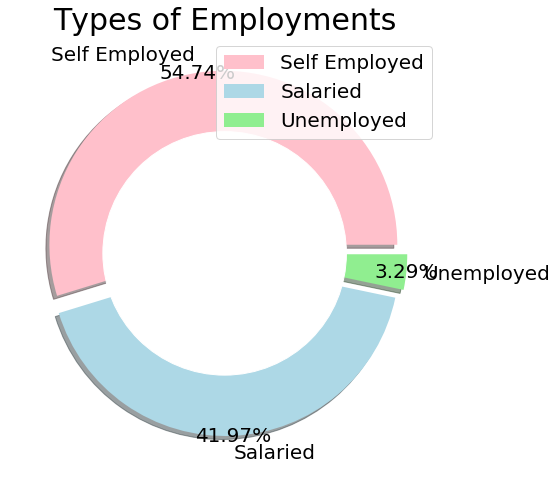

In [60]:
# plotting a donut chart

size = [127635, 97858, 7661]
colors = ['pink', 'lightblue', 'lightgreen']
labels = "Self Employed", "Salaried", "Unemployed" 
explode = [0.05, 0.05, 0.05]

circle = plt.Circle((0, 0), 0.7, color = 'white')


plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, pctdistance = 1, autopct = '%.2f%%')
plt.title('Types of Employments', fontsize = 30)
plt.axis('off')
p = plt.gcf()
p.gca().add_artist(circle)
plt.legend()
plt.show()

### Null value check after imputation/filling null values

In [61]:
print(dataset.isnull().sum())
print('-' * 30)
print(test_data.isnull().sum())
#There are No NULL values now

UniqueID                               0
disbursed_amount                       0
asset_cost                             0
ltv                                    0
branch_id                              0
supplier_id                            0
manufacturer_id                        0
Current_pincode_ID                     0
Date.of.Birth                          0
Employment.Type                        0
DisbursalDate                          0
State_ID                               0
Employee_code_ID                       0
MobileNo_Avl_Flag                      0
Aadhar_flag                            0
PAN_flag                               0
VoterID_flag                           0
Driving_flag                           0
Passport_flag                          0
PERFORM_CNS.SCORE                      0
PERFORM_CNS.SCORE.DESCRIPTION          0
PRI.NO.OF.ACCTS                        0
PRI.ACTIVE.ACCTS                       0
PRI.OVERDUE.ACCTS                      0
PRI.CURRENT.BALA

###  Dummification of convertible variables 'Employment.Type', 'State_ID', 'branch_id' and 'manufacturer_id'

In [62]:
dataset = pd.get_dummies(dataset, columns = ['Employment.Type','State_ID','branch_id','manufacturer_id'], drop_first = True)

### Shape check after dummification

In [63]:
dataset.shape

(233154, 151)

In [64]:
dataset.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'supplier_id',
       'Current_pincode_ID', 'Date.of.Birth', 'DisbursalDate',
       'Employee_code_ID', 'MobileNo_Avl_Flag',
       ...
       'manufacturer_id_1', 'manufacturer_id_2', 'manufacturer_id_3',
       'manufacturer_id_4', 'manufacturer_id_5', 'manufacturer_id_6',
       'manufacturer_id_7', 'manufacturer_id_8', 'manufacturer_id_9',
       'manufacturer_id_10'],
      dtype='object', length=151)

### Dummification of convertible variables 'Employment.Type', 'State_ID', 'branch_id', 'manufacturer_id'

In [65]:
test_data = pd.get_dummies(test_data, columns = ['Employment.Type','State_ID','branch_id','manufacturer_id'], drop_first = True)

### Shape check after dummification

In [66]:
test_data.shape

(112392, 150)

In [67]:
test_data.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'supplier_id',
       'Current_pincode_ID', 'Date.of.Birth', 'DisbursalDate',
       'Employee_code_ID', 'MobileNo_Avl_Flag',
       ...
       'manufacturer_id_1', 'manufacturer_id_2', 'manufacturer_id_3',
       'manufacturer_id_4', 'manufacturer_id_5', 'manufacturer_id_6',
       'manufacturer_id_7', 'manufacturer_id_8', 'manufacturer_id_9',
       'manufacturer_id_10'],
      dtype='object', length=150)

### Target variable to categorical variable

In [68]:
dataset['loan_default'] = dataset['loan_default'].astype('category')
print(pd.factorize(dataset['loan_default']))

(array([0, 1, 0, ..., 0, 0, 0]), CategoricalIndex([0, 1], categories=[0, 1], ordered=False, dtype='category'))


In [69]:
# Dropping categorical columns which can't be dummified
dataset=dataset.drop(columns='supplier_id')
test_data=test_data.drop(columns='supplier_id')
dataset=dataset.drop(columns='Current_pincode_ID')
test_data=test_data.drop(columns='Current_pincode_ID')
dataset=dataset.drop(columns='Employee_code_ID')
test_data=test_data.drop(columns='Employee_code_ID')
# Dropping the 'MobileNo_Avl_Flag' as this is '1' for both Train and Test data for all records(constant value column)
dataset=dataset.drop(columns='MobileNo_Avl_Flag')
test_data=test_data.drop(columns='MobileNo_Avl_Flag')

In [70]:
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,manufacturer_id_1,manufacturer_id_2,manufacturer_id_3,manufacturer_id_4,manufacturer_id_5,manufacturer_id_6,manufacturer_id_7,manufacturer_id_8,manufacturer_id_9,manufacturer_id_10
0,420825,50578,58400,89.55,01-01-84,03-08-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,31-07-85,26-09-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,417566,53278,61360,89.63,24-08-85,01-08-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,624493,57513,66113,88.48,30-12-93,26-10-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,539055,52378,60300,88.39,09-12-77,26-09-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
test_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,manufacturer_id_1,manufacturer_id_2,manufacturer_id_3,manufacturer_id_4,manufacturer_id_5,manufacturer_id_6,manufacturer_id_7,manufacturer_id_8,manufacturer_id_9,manufacturer_id_10
0,655269,53478,63558,86.54,01-01-74,03-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,723482,55513,63163,89.45,20-05-85,20-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,758529,65282,84320,79.93,14-10-95,29-11-18,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,763449,46905,63896,76.58,01-06-73,29-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,708663,51428,63896,86.08,01-06-72,17-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
import datetime as DT

now = pd.Timestamp('now')
dataset['Date.of.Birth'] = pd.to_datetime(dataset['Date.of.Birth'], format='%d-%m-%y')  
dataset['Date.of.Birth'] = dataset['Date.of.Birth'].where(dataset['Date.of.Birth'] < now, dataset['Date.of.Birth'] -  np.timedelta64(100, 'Y'))   
dataset['Age'] = (now - dataset['Date.of.Birth']).astype('<m8[Y]')    

### Age distribution

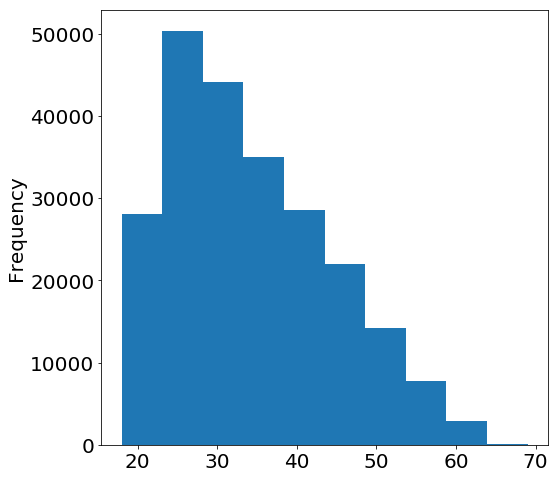

In [73]:
dataset['Age'].plot.hist()

In [74]:
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,manufacturer_id_2,manufacturer_id_3,manufacturer_id_4,manufacturer_id_5,manufacturer_id_6,manufacturer_id_7,manufacturer_id_8,manufacturer_id_9,manufacturer_id_10,Age
0,420825,50578,58400,89.55,1984-01-01,03-08-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,35.0
1,537409,47145,65550,73.23,1985-07-31,26-09-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,33.0
2,417566,53278,61360,89.63,1985-08-24,01-08-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,33.0
3,624493,57513,66113,88.48,1993-12-30,26-10-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,25.0
4,539055,52378,60300,88.39,1977-12-09,26-09-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,41.0


In [75]:
# Converting DOB to Age
now = pd.Timestamp('now')
test_data['Date.of.Birth'] = pd.to_datetime(test_data['Date.of.Birth'], format='%d-%m-%y')    
test_data['Date.of.Birth'] = test_data['Date.of.Birth'].where(test_data['Date.of.Birth'] < now, test_data['Date.of.Birth'] -  np.timedelta64(100, 'Y')) 
test_data['Age'] = (now - test_data['Date.of.Birth']).astype('<m8[Y]')    

### Age distribution

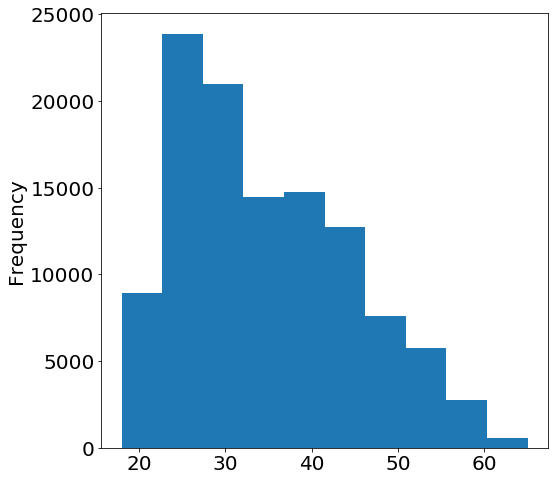

In [76]:
test_data['Age'].plot.hist()

In [77]:
test_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,Date.of.Birth,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,manufacturer_id_2,manufacturer_id_3,manufacturer_id_4,manufacturer_id_5,manufacturer_id_6,manufacturer_id_7,manufacturer_id_8,manufacturer_id_9,manufacturer_id_10,Age
0,655269,53478,63558,86.54,1974-01-01,03-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,45.0
1,723482,55513,63163,89.45,1985-05-20,20-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,33.0
2,758529,65282,84320,79.93,1995-10-14,29-11-18,1,1,0,0,...,0,0,0,1,0,0,0,0,0,23.0
3,763449,46905,63896,76.58,1973-06-01,29-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,45.0
4,708663,51428,63896,86.08,1972-06-01,17-11-18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,46.0


### Dataframes info print

In [78]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Columns: 148 entries, UniqueID to Age
dtypes: category(1), datetime64[ns](1), float64(4), int64(27), object(1), uint8(114)
memory usage: 84.3+ MB


In [79]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Columns: 147 entries, UniqueID to Age
dtypes: datetime64[ns](1), float64(4), int64(27), object(1), uint8(114)
memory usage: 40.5+ MB


In [80]:
# Dropping 'Date.of.Birth' as we have 'Age'
dataset=dataset.drop(columns='Date.of.Birth')
test_data=test_data.drop(columns='Date.of.Birth')
# Dropping 'DisbursalDate'
dataset=dataset.drop(columns='DisbursalDate')
test_data=test_data.drop(columns='DisbursalDate')

### Converting to float for model training

In [81]:
dataset=dataset.astype('float64',copy=True)

In [82]:
test_data=test_data.astype('float64',copy=True)

### Dropping the UniqueID column

In [83]:
dataset=dataset.drop('UniqueID',axis=1)
test_data=test_data.drop('UniqueID',axis=1)

### Dataframes shape check

In [84]:
dataset.shape

(233154, 145)

In [85]:
test_data.shape

(112392, 144)

### Upsampling due to slight imbalance classes

In [86]:
# Separate majority and minority classes
dataset_majority = dataset[dataset.loan_default==0]
dataset_minority = dataset[dataset.loan_default==1]
 
# Upsample minority class
dataset_minority_upsampled = resample(dataset_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=182543,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
dataset_upsampled = pd.concat([dataset_majority, dataset_minority_upsampled])
 
# Display new class counts
dataset_upsampled.loan_default.value_counts()

1.0    182543
0.0    182543
Name: loan_default, dtype: int64

### Separate input features (X) and target variable (Y)

In [87]:
y = dataset_upsampled.loan_default
X = dataset_upsampled.drop('loan_default', axis=1)

### Split-out validation dataset

In [88]:
validation_size = 0.35
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X,y, test_size=validation_size, random_state=seed)

### Normalizing variables

In [89]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation= scaler.transform(X_validation)

### Training the model

In [90]:
clf_ups = LogisticRegression()
clf_ups.fit(X_train, Y_train)

/Users/priyavivekbhandarkar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Predict on training set

In [91]:
pred_ups = clf_ups.predict(X_validation)

In [92]:
# Is our model predicting just one class?
print( np.unique( pred_ups ) )

[0. 1.]


### Training and Testing Accuracy

In [93]:
print("Training Accuracy: ", clf_ups.score(X_train, Y_train))
print('Testing Accuarcy: ',clf_ups.score(X_validation, Y_validation))

Training Accuracy:  0.6110406438970944
Testing Accuarcy:  0.6099811396060447


In [94]:
pred_ups[0:100]

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.])

### Printing confusion matrix

In [95]:
from sklearn.metrics import confusion_matrix

confusion_matrix1 = confusion_matrix(Y_validation,pred_ups)
print(confusion_matrix1)

[[36606 27174]
 [22663 41338]]


### Making a classification report

In [96]:
cr = classification_report(Y_validation,  pred_ups)
print(cr)

              precision    recall  f1-score   support

         0.0       0.62      0.57      0.59     63780
         1.0       0.60      0.65      0.62     64001

   micro avg       0.61      0.61      0.61    127781
   macro avg       0.61      0.61      0.61    127781
weighted avg       0.61      0.61      0.61    127781



### Printing Average Precision Score

In [97]:
from sklearn.metrics import average_precision_score

apc = average_precision_score(Y_validation, pred_ups)
print('Average Precision Score :', apc)

Average Precision Score : 0.5670716954769819


### ROC curve

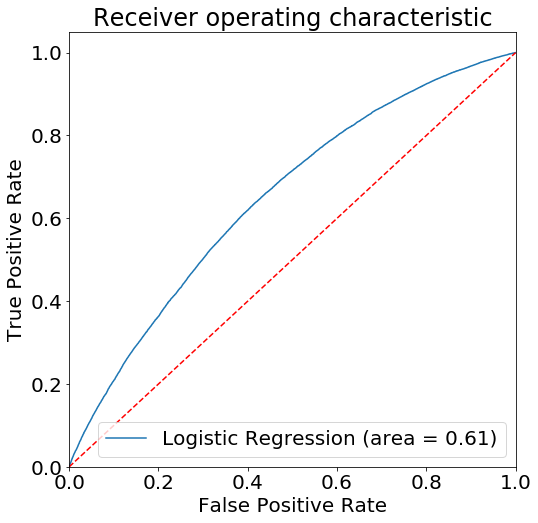

In [98]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_validation, clf_ups.predict(X_validation))
fpr, tpr, thresholds = roc_curve(Y_validation, clf_ups.predict_proba(X_validation)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

### Test data min-max scalar transform

In [99]:
X_test=test_data
X_test = scaler.transform(X_test)

### Prediction on test data

In [100]:
Y_pred = clf_ups.predict(X_test)
Y_pred=Y_pred.astype('int64')

### Submission file preperation

In [101]:
# Lets look at the submission file

submission = pd.read_csv('sample_submission_24jSKY6.csv')

submission.head()

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0


In [102]:
#  Let's create a submission file
unique_id = pd.read_csv("test.csv",skipinitialspace=True)['UniqueID']

# Create a DataFrame with the Uniques ids and our prediction of loan default
submission = pd.DataFrame({'UniqueID': unique_id,'loan_default': Y_pred})

# Visualize the first 5 rows
submission.head()

,UniqueID,loan_default
0,655269,1
1,723482,1
2,758529,1
3,763449,1
4,708663,1


### Prediction Count Check

In [103]:
submission['loan_default'].value_counts()

0    59658
1    52734
Name: loan_default, dtype: int64

### Writing predictions to CSV

In [104]:
submission.to_csv('sample_submission.csv',index=False)

# Conclusion

* We have tried many models e.g. XGBoost, Adaboost, ANN,RandomForest, though the accuracy on training dataset was good after fitting on these models, the validation and testing(unseen data) accuracy was not good, hence they were ove-rfitting.

* The best accuracy/roc-auc we got from GLM-Generalized Linear Model(Logistic Regression) and it was not overfitting as well.

* The dataset provided was tricky and needed pre-processing after EDA and Visualisation.

* Also we hope that our code will help L&T improve already existing model or give some insight for the same.


Thank you,

Priya & Roshan

Team-We support ML